In [13]:
import numpy as np
import h5py
import scipy.stats as stat
import os
import matplotlib.pyplot as plt

In [14]:
score_path = '../scores/'
optimization_results_path = './optimization_results_path/optimization_results_without_sensitivity.hdf5'
params_path = '../params.hdf5'

In [15]:
def collapse(mat):
    collapsed = []
    row_size = np.shape(mat)[1]
    for row in mat:
        collapsed.append(sum(row)/float(row_size))
    return np.array(collapsed)

In [25]:
# Normalizing every matrix by the top 0.1% of all the sensitivity value. 
def normalize_dict(sensitivity_dictionary):
    as_list = []
    for mat in sensitivity_dictionary.values():
        as_list.append(mat)
    as_list_flattened = np.reshape(np.concatenate(as_list, axis=1), (np.size(as_list), ))
    sorted_list = sorted(as_list_flattened, reverse=True)
    mean_top = np.median(np.array(sorted_list[0:int(len(sorted_list)*0.1)]))
    
    print('Normalizing sensitivity dictionary')
    print(mean_top)
    
    for key in sensitivity_dictionary.keys():
        curr_mat = sensitivity_dictionary[key]
        curr_mat = np.array(curr_mat)/float(mean_top)
        for i in range(len(curr_mat)):
            for j in range(len(curr_mat[i])):
                if curr_mat[i][j] > 1:
                    curr_mat[i][j] = 1
        sensitivity_dictionary[key] = curr_mat
    return sensitivity_dictionary

In [26]:
def construct_score_sensitivity_dict(ordered_stim_list, ordered_score_function_list):
    norm_score_prefix = 'norm_pin_scores_'
    sensitivity_mat_prefix = 'sensitivity_mat_'
    pin_score_dict = {}
    sensitivity_dict = {}
    collapsed_sensitivity_dict = {}
    number_of_params = h5py.File(params_path, 'r')['param_num'][:][0]
    for stim in ordered_stim_list:
        score_file_name = stim + '_scores.hdf5'
        score_file = h5py.File(score_path + score_file_name, 'r')
        curr_pin_list = []
        curr_sensitivity_list_collapesed = []
        curr_sensitivity_list = []
        for function_name in ordered_score_function_list:
            curr_pin_score = score_file[norm_score_prefix+function_name][:].T[0]
            curr_sensitivity = score_file[sensitivity_mat_prefix+function_name][:].T[0]
            pin_len = len(curr_pin_score)
            sensitivity_len = len(curr_sensitivity)
            curr_sensitivity = np.reshape(curr_sensitivity, (sensitivity_len//number_of_params, number_of_params)).T
            curr_sensitivity_list.append(curr_sensitivity)
            curr_sensitivity_collapsed = collapse(curr_sensitivity)
            curr_pin_list.append(curr_pin_score)
            curr_sensitivity_list_collapesed.append(curr_sensitivity_collapsed)
        pin_score_dict[stim] = curr_pin_list
        sensitivity_dict[stim] = curr_sensitivity_list
        collapsed_sensitivity_dict[stim] = curr_sensitivity_list_collapesed
    return pin_score_dict, sensitivity_dict, normalize_dict(collapsed_sensitivity_dict)

In [27]:
def load_optimization_result(path):
    opt_result = h5py.File(path, 'r')
    ordered_score_function_list_binary = opt_result['ordered_score_function_list'][:]
    ordered_score_function_list = [e.decode('ascii') for e in ordered_score_function_list_binary]
    stims_optimal_order_binary = opt_result['stims_optimal_order'][:]
    stims_optimal_order = [e.decode('ascii') for e in stims_optimal_order_binary]
    results_dict = {}
    for stim in stims_optimal_order:
        results_dict[stim] = opt_result[stim][:]
    return stims_optimal_order, ordered_score_function_list, results_dict

In [28]:
stims_optimal_order, ordered_score_function_list, opt_result = load_optimization_result(optimization_results_path)
pin_score_dict, sensitivity_dict, collapsed_sensitivity_dict = construct_score_sensitivity_dict(stims_optimal_order, ordered_score_function_list)

Normalizing sensitivity dictionary
1793.7922410581562


In [29]:
# Plots the sensitivity matrix as a heat map. 
# Vertical axis is the parameter index and 
# Horizontal axis is the numbering of each param set.
def plot_heat_map(mat, v_max, plot_title=''):
    # Heat Map for all elementary effects.
    plt.figure(figsize=(10,7))
    plt.imshow(mat, cmap='hot', aspect='auto', vmax=v_max)
    plt.xlabel('Parameter Set')
    plt.ylabel('Parameter #')
    plt.title('All elementary effects: ' + plot_title)
    plt.show()

In [30]:
def plot_lin_comb_as_heat_map(stim_name, weight_vector, sensitivity_dict):
    lin_comb_mat = sum([sensitivity_dict[stim_name][i]*weight_vector[i] for i in range(len(weight_vector))])
#     print('Unweighted Mat: ')
#     for i in range(len(ordered_score_function_list)):
#         mat = sensitivity_dict[stim_name][i]
#         plot_heat_map(mat, None, stim_name + '_' + ordered_score_function_list[i] + ', index ' + str(i))
#     print('Weighted Mat: ')
#     plot_heat_map(lin_comb_mat, None)
#     print('Scores: ')
    plt.figure(figsize=(15,7))
    plt.scatter(range(1000), sum([pin_score_dict[stim_name][i]*weight_vector[i] for i in range(len(weight_vector))]))

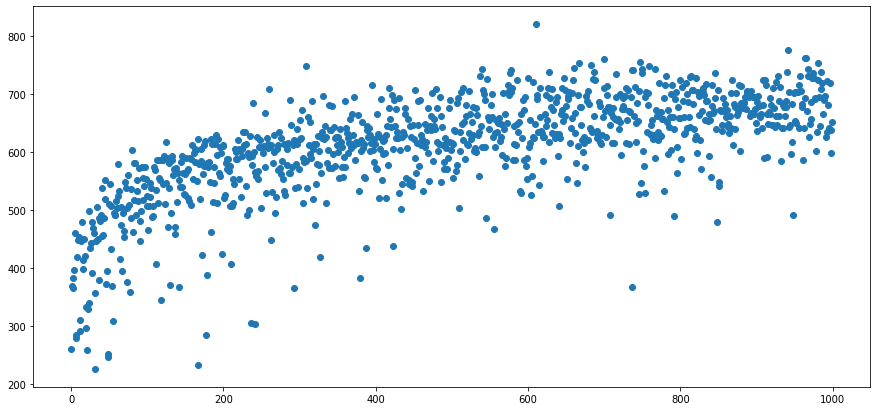

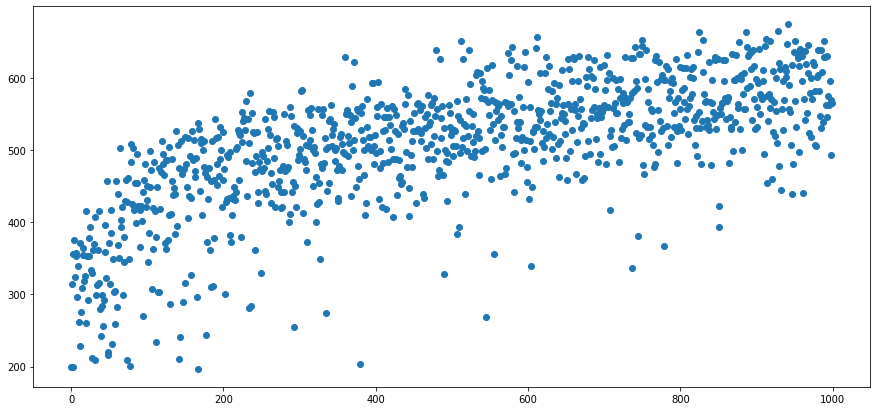

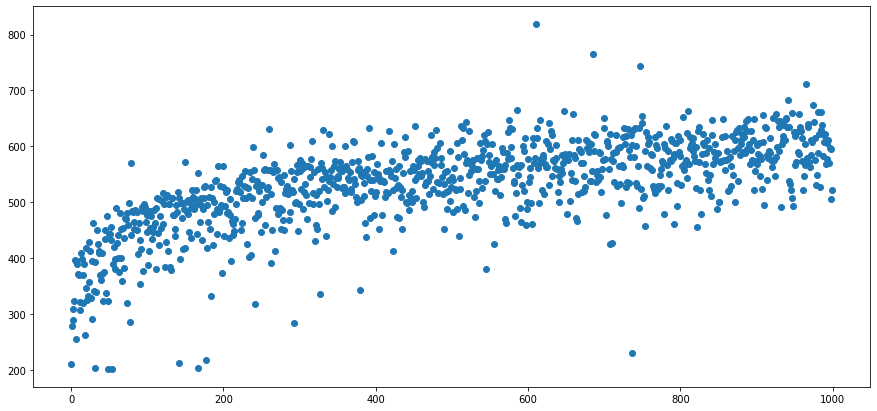

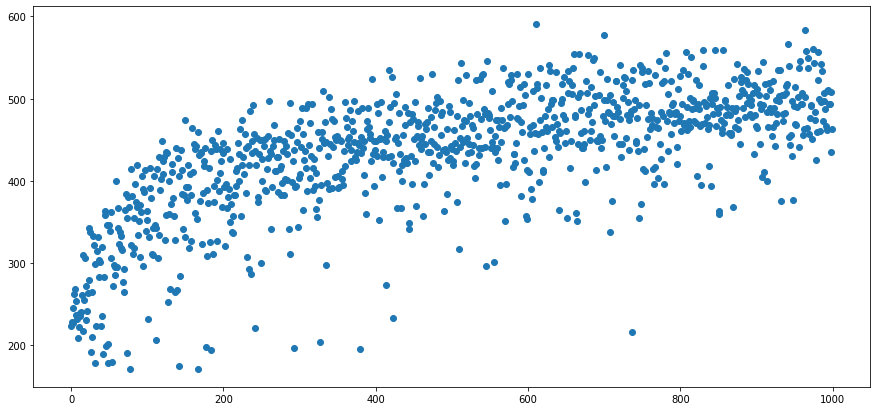

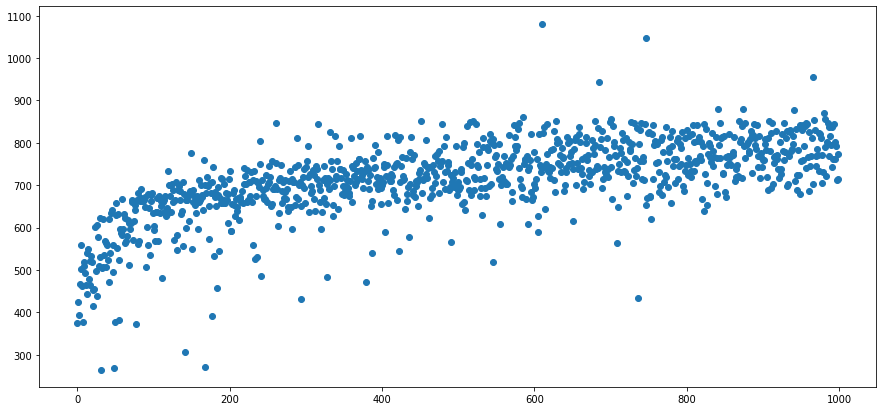

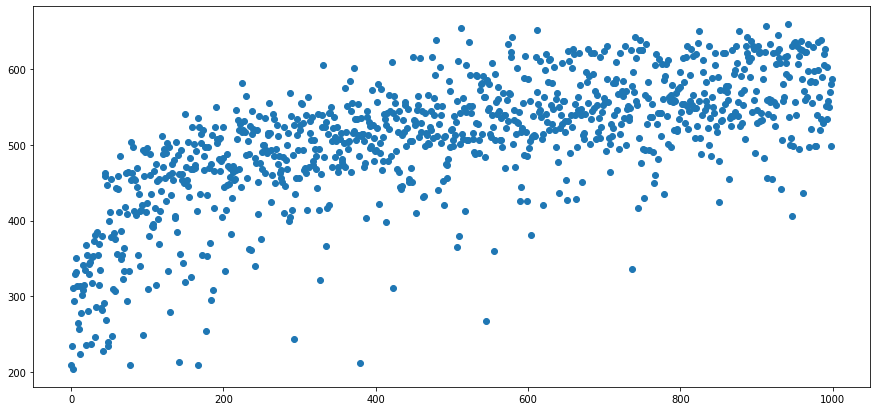

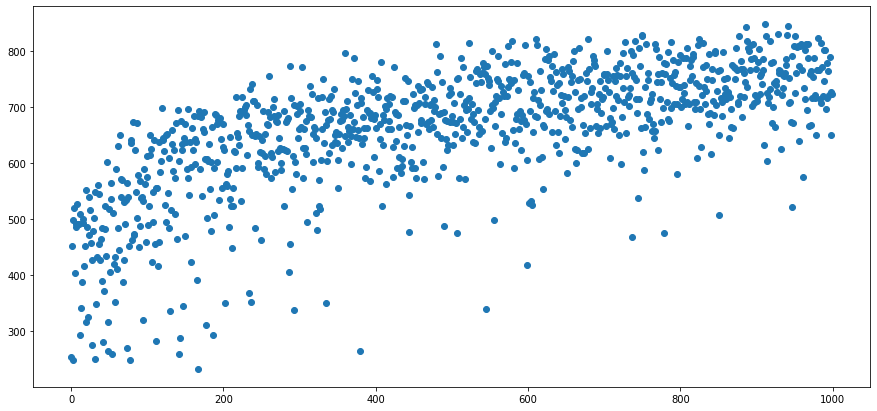

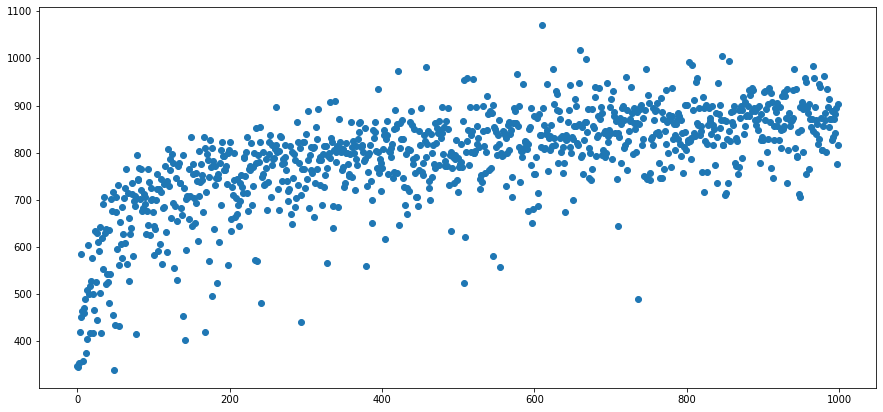

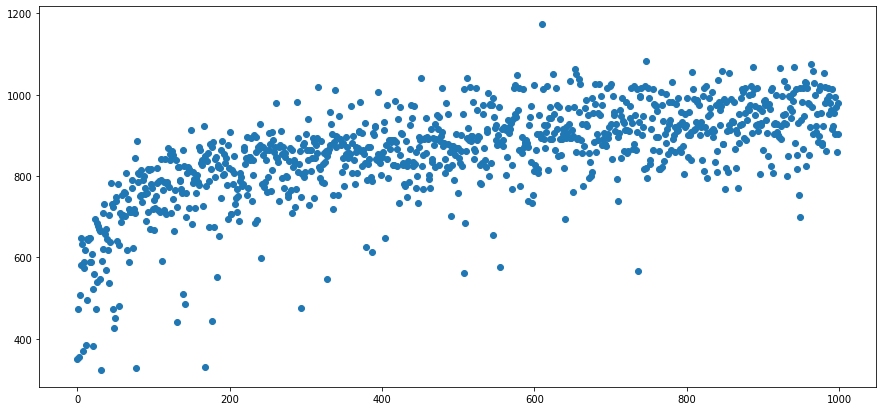

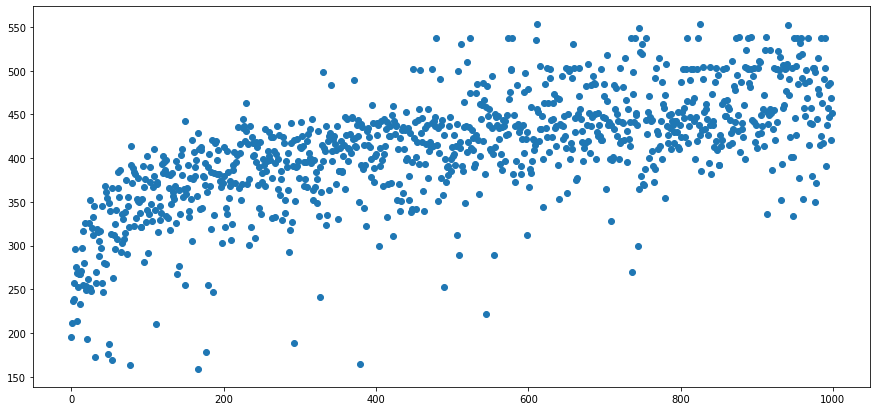

In [31]:
for stim in stims_optimal_order[:10]:
    weight_vec = opt_result[stim]
    plot_lin_comb_as_heat_map(stim, weight_vec, sensitivity_dict)

In [32]:
def plot_collapsed(stim_name):
    fig, ax = plt.subplots(figsize=(25, 20))
    im = ax.imshow((np.array(collapsed_sensitivity_dict[stim_name]).T))

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(ordered_score_function_list)))
    ax.set_yticks(np.arange(12))
    # ... and label them with the respective list entries
    ax.set_xticklabels(ordered_score_function_list)
    ax.set_yticklabels(['param #' + str(i) for i in range(1, 14)])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    ax.set_title("Sensitivity Analysis: "+ stim_name)
    plt.show()

79


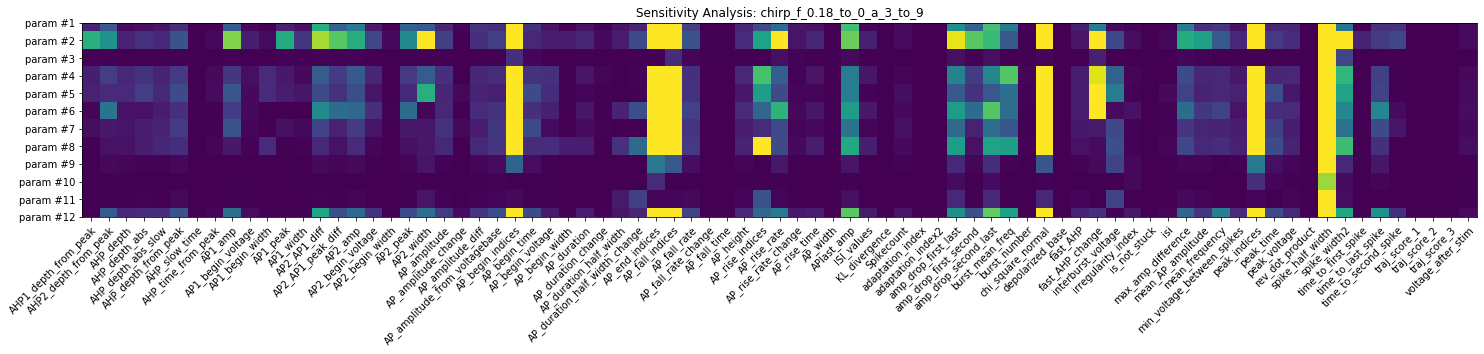

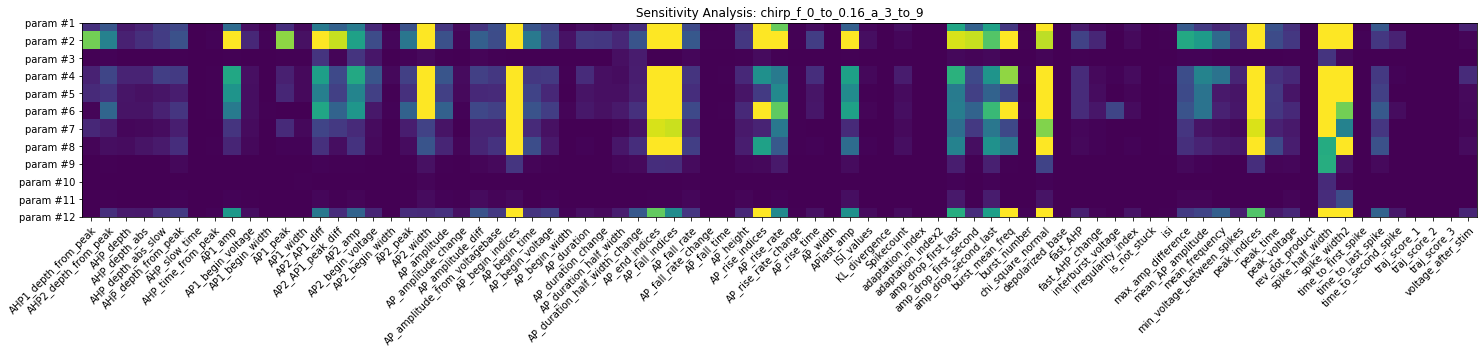

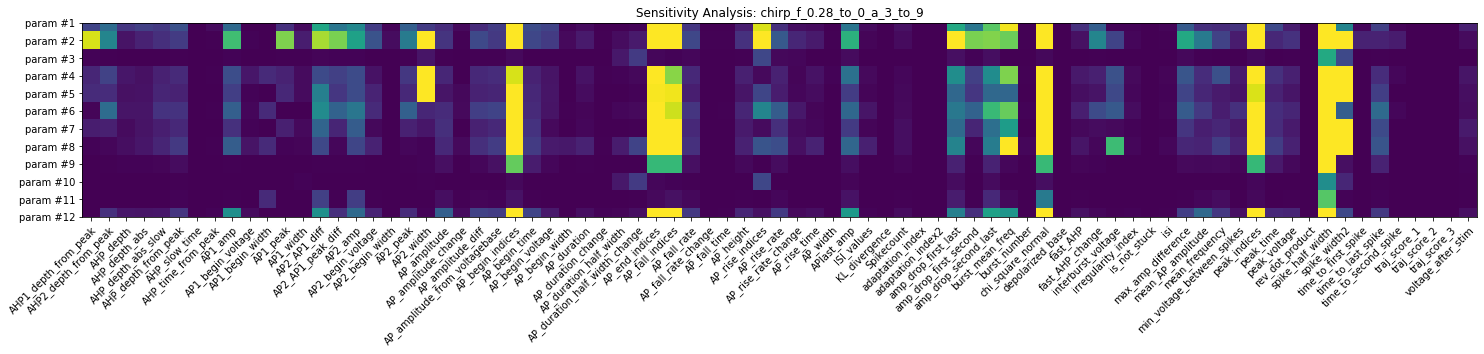

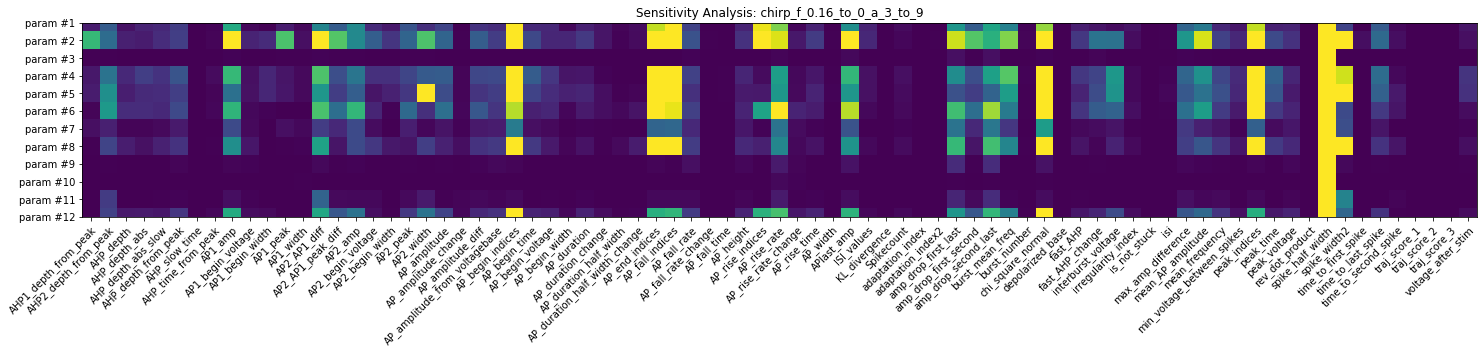

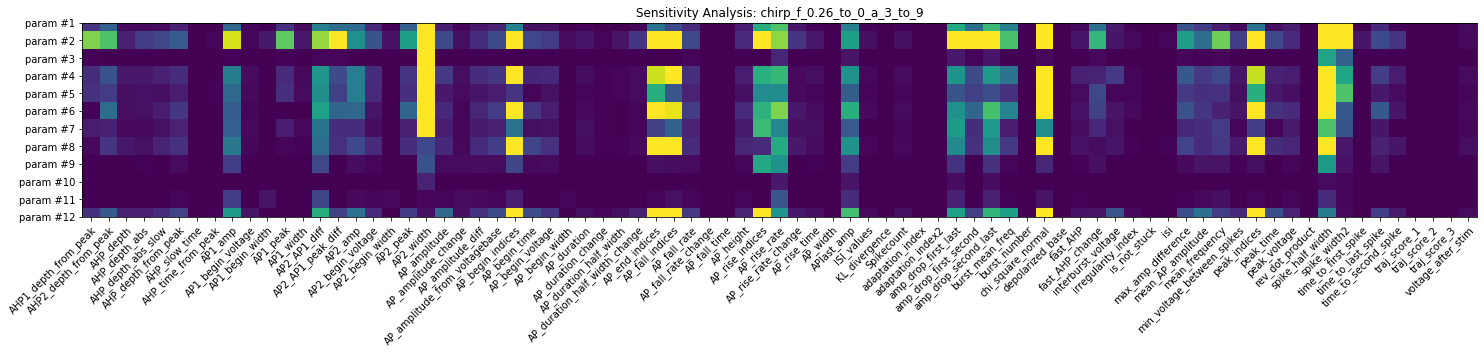

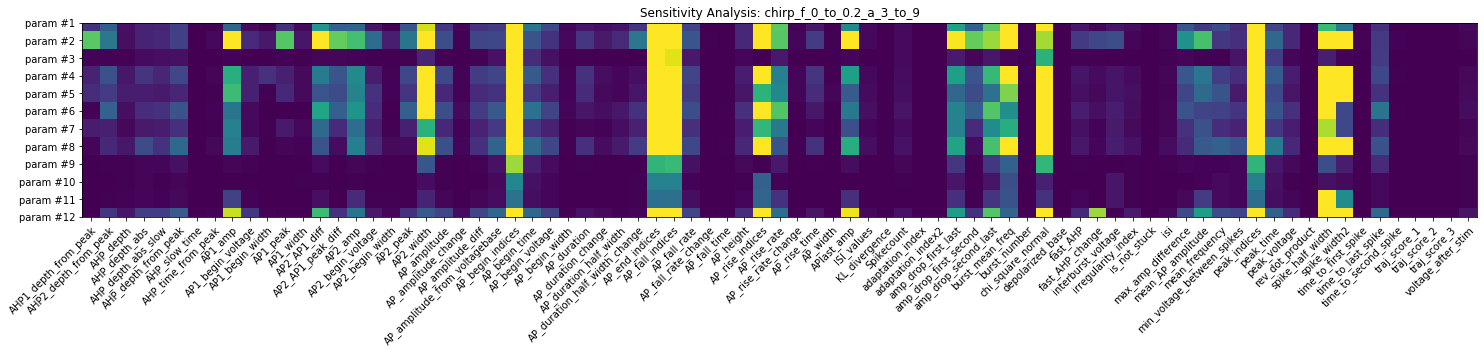

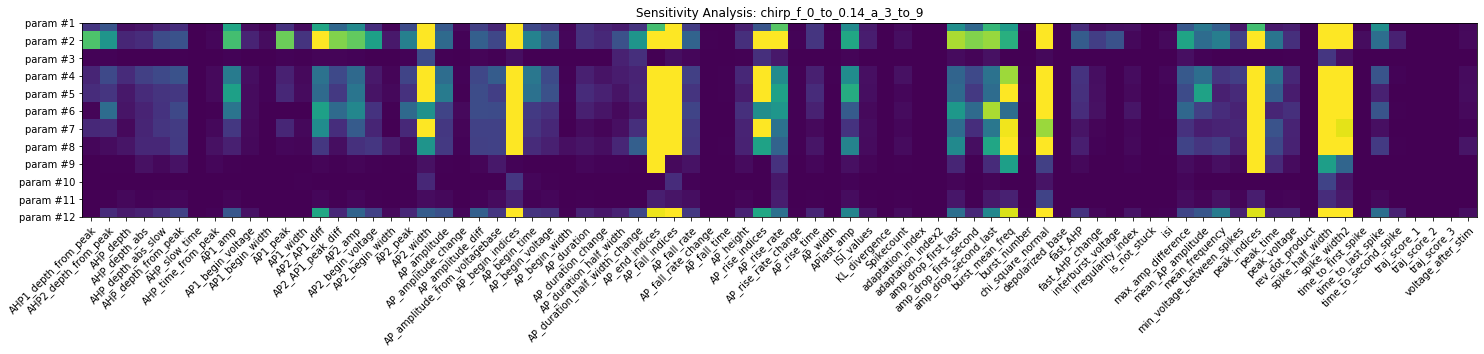

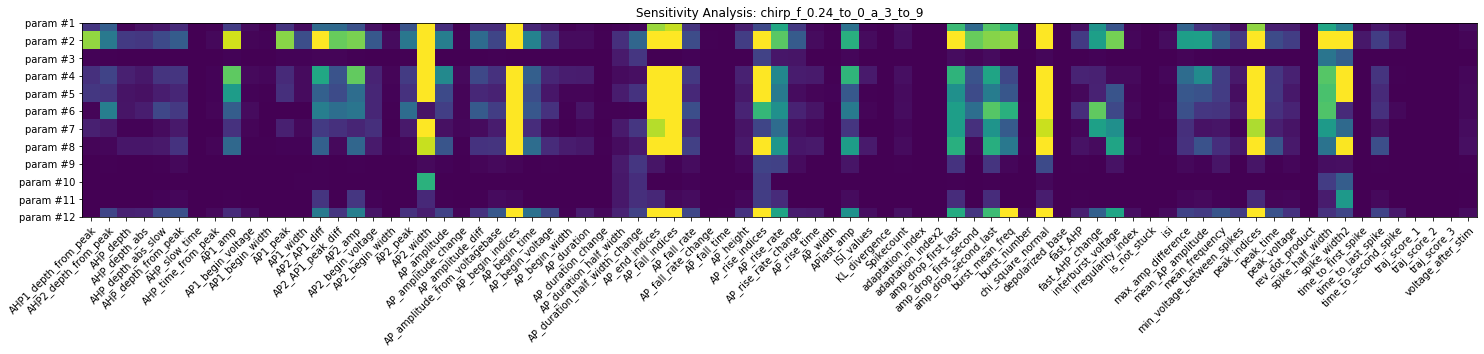

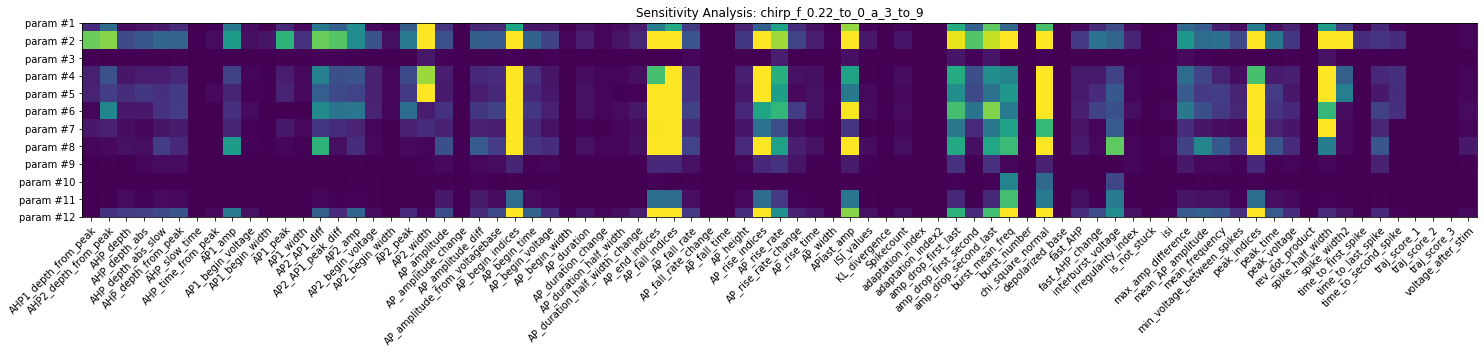

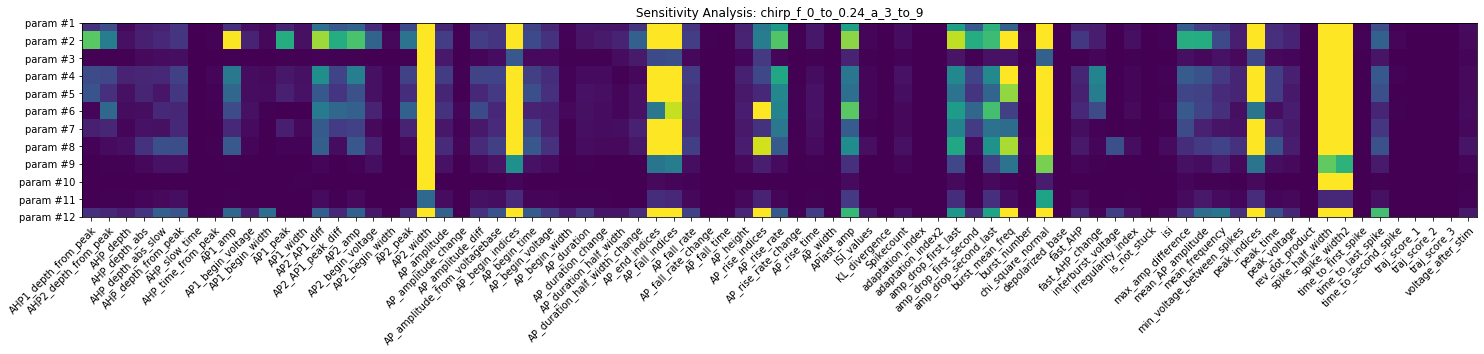

In [33]:
print(len(ordered_score_function_list))
for stim in stims_optimal_order[:10]:
    plot_collapsed(stim)